# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
#progress bar
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from google.colab import output
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

# 2. Load Data

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1bL5ILyUYtHOC1IiCfcB56LjDhf6OwboU' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1bL5ILyUYtHOC1IiCfcB56LjDhf6OwboU" -O training.csv && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1eHl-ngN0q8qzq3l1uXfF_dVGZNU7P8YY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1eHl-ngN0q8qzq3l1uXfF_dVGZNU7P8YY" -O testing.csv && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VqqVTbbAm1MnD5SqjWF7vow3fjSlLWX-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1VqqVTbbAm1MnD5SqjWF7vow3fjSlLWX-" -O gabriel_data.csv && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1d19hAQfjvRxOtbYfYSDUWhTVQ2WWsM22' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d19hAQfjvRxOtbYfYSDUWhTVQ2WWsM22" -O gabriel_final.csv && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CqW36Yx-Lrp3fjGin9_jfDfYwDExPPM3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1CqW36Yx-Lrp3fjGin9_jfDfYwDExPPM3" -O logs.csv && rm -rf /tmp/cookies.txt

gabriel_0 = pd.read_csv('gabriel_data.csv')
gabriel = pd.read_csv('gabriel_final.csv')
logs = pd.read_csv('logs.csv')

gabriel['RHO'] = logs['RHO']
gabriel['U'] = logs['U']
gabriel['ILD'] = logs['ILD']
gabriel['DT'] = logs['DT']
gabriel['GR'] = logs['GR']

old_train = pd.read_csv('training.csv')
old_test = pd.read_csv('testing.csv')

output.clear()

In [3]:
old_train[['UWI']] = old_train[['UWI']].astype('str')
gabriel[['UWI']] = gabriel[['UWI']].astype('str')
gabriel[['UWI']] = gabriel[['UWI']].astype('str')

gabriel['DST_start'] = gabriel_0['DST Start Depth (MD) (m)']
gabriel['DST_end'] = gabriel_0['DST End Depth (MD) (m)']

In [4]:
uwi = []
for i in gabriel['UWI'].values:
  uwi.append(i.rstrip('_'))

gabriel[['UWI']] = uwi
a,train_index,c = np.intersect1d(gabriel['UWI'].values,old_train['UWI'].values, return_indices=True)
d,test_index,e = np.intersect1d(gabriel['UWI'].values,old_test['UWI'].values, return_indices=True)

train = gabriel.iloc[train_index,:].reset_index().drop('index',axis=1)
test = gabriel.iloc[test_index,:].reset_index().drop('index',axis=1)

# 3. Nearest Neighbors

## 3.1 Train Data

In [5]:
coords = train[['UWI','SurfaceLatitude_NAD83','SurfaceLongitude_NAD83','Field','BHT','TrueTemp']]
coords 

,UWI,SurfaceLatitude_NAD83,SurfaceLongitude_NAD83,Field,BHT,TrueTemp
0,100010107020W500,55.027981,-116.903553,Duvernay,48.330000,60.970000
1,100010608109W500,55.987511,-115.390554,Duvernay,34.260000,63.980000
2,100011206021W400,54.167413,-113.002674,Duvernay,29.000000,39.070000
3,100011506915W500,54.969037,-116.188158,Duvernay,64.000000,69.470000
4,100011804403W500,52.787328,-114.415621,Duvernay,68.000000,75.230000
...,...,...,...,...,...,...
610,42493318190000,29.078411,-98.110357,Eaglebine,76.666667,96.105556
611,42493319370000,29.032056,-98.174977,Eaglebine,78.888889,100.472222
612,42507007550000,28.774927,-99.562068,Eaglebine,65.555556,78.161111
613,42507312960000,29.077015,-100.006558,Eaglebine,67.222222,94.794444


In [6]:
coords['lat'] = np.nan
coords['lon'] = np.nan

In [7]:
latitudes = ['SurfaceLatitude_NAD83']
longitudes = ['SurfaceLongitude_NAD83']

for i in latitudes:
  coords['lat'].fillna(coords[i],inplace=True)

for i in longitudes:
  coords['lon'].fillna(coords[i],inplace=True)  

In [8]:
coords = coords[['UWI','lat','lon','Field','BHT','TrueTemp']]
coords.isna().sum()

UWI         0
lat         0
lon         0
Field       0
BHT         0
TrueTemp    0
dtype: int64

In [9]:
# Original script By Erick Gutierrez Bossa: https://www.linkedin.com/in/erick-enrique-gutierrez-bossa/

# ----------------------------Find Nearest Neighbors by Euclidean Distance-----------------------#
def distance(x, y,x0=0,y0=0):
    return np.sqrt((x-x0)**2+(y-y0)**2)

def NearestNeighbors(coords,neighbors):

  l=[]

  for i0 in range(len(coords)):
      d=[]
      d_index=[]
      for i in range(len(coords)):
          d.append(distance(coords.iloc[i][1],coords.iloc[i][2],coords.iloc[i0][1],coords.iloc[i0][2])) # Computes distances to Well i0
          d_index.append(i)# Append index distances to d 
      _, list2 = zip(*sorted(zip(d, d_index))) # Sort in ascending order
      l.append(list(list2)[1:neighbors+1])

  coords['NN_list_idx'] = l # Returns a index list of the neighbors but using the coords df
  coords['NN_list'] = coords['NN_list_idx'].apply(lambda x: [list(coords.index.values)[x[i]] for i in range(len(x))])
  neighbors = coords.drop('NN_list_idx',axis=1)  
  
  return neighbors

# -------------------------------Define a function to retrieve neighbors---------------------------#
def get_neighbors(well):
  return neighbors.iloc[well,6]

In [10]:
neighbors = NearestNeighbors(coords,5)
neighbors

,UWI,lat,lon,Field,BHT,TrueTemp,NN_list
0,100010107020W500,55.027981,-116.903553,Duvernay,48.330000,60.970000,"[298, 337, 208, 107, 355]"
1,100010608109W500,55.987511,-115.390554,Duvernay,34.260000,63.980000,"[253, 344, 167, 130, 48]"
2,100011206021W400,54.167413,-113.002674,Duvernay,29.000000,39.070000,"[54, 371, 218, 357, 7]"
3,100011506915W500,54.969037,-116.188158,Duvernay,64.000000,69.470000,"[237, 78, 186, 31, 187]"
4,100011804403W500,52.787328,-114.415621,Duvernay,68.000000,75.230000,"[345, 240, 109, 174, 264]"
...,...,...,...,...,...,...,...
610,42493318190000,29.078411,-98.110357,Eaglebine,76.666667,96.105556,"[609, 604, 607, 608, 605]"
611,42493319370000,29.032056,-98.174977,Eaglebine,78.888889,100.472222,"[608, 607, 600, 604, 610]"
612,42507007550000,28.774927,-99.562068,Eaglebine,65.555556,78.161111,"[478, 472, 614, 473, 467]"
613,42507312960000,29.077015,-100.006558,Eaglebine,67.222222,94.794444,"[585, 580, 614, 586, 479]"


In [11]:
import plotly.express as px
fig = px.scatter(neighbors, x=neighbors.lon, y=neighbors.lat, color=neighbors.Field, size=neighbors.TrueTemp, hover_data=[neighbors.BHT, neighbors.index,neighbors.NN_list])
fig.update_layout(
    width = 1400,
    height = 600,
    title = "Neighbor Wells")

fig.show()

In [12]:
# We can conclude from here:
"""
1. Eaglebine Average True Temperature > Duvernay Average True Temperature
"""
coords.groupby(by='Field')['TrueTemp'].mean()

Field
Duvernay      75.049167
Eaglebine    114.340356
Name: TrueTemp, dtype: float64

In [13]:
"""
2. Therefore, the same for BHT
"""
coords.groupby(by='Field')['BHT'].mean()

Field
Duvernay     60.397339
Eaglebine    95.522176
Name: BHT, dtype: float64

## 3.2 Test Data

In [14]:
test_coords = test[['UWI','SurfaceLatitude_NAD83','SurfaceLongitude_NAD83','Field','BHT','TrueTemp']].set_index(np.arange(615,len(gabriel)))
test_coords.head()

,UWI,SurfaceLatitude_NAD83,SurfaceLongitude_NAD83,Field,BHT,TrueTemp
615,100012404516W502,52.889725,-116.183134,Duvernay,93.33,NaN
616,100012805703W500,53.951223,-114.379260,Duvernay,37.00,NaN
617,100020206419W500,54.503527,-116.758284,Duvernay,82.22,NaN
618,100020605904W500,54.066619,-114.586167,Duvernay,78.89,NaN
619,100020606216W500,54.328769,-116.385865,Duvernay,77.22,NaN


In [15]:
test_coords['lat'] = np.nan
test_coords['lon'] = np.nan

In [16]:
latitudes = ['SurfaceLatitude_NAD83']
longitudes = ['SurfaceLongitude_NAD83']

for i in latitudes:
  test_coords['lat'].fillna(test_coords[i],inplace=True)

for i in longitudes:
  test_coords['lon'].fillna(test_coords[i],inplace=True)

In [17]:
test_coords = test_coords[['UWI','lat','lon','Field','BHT']]
test_coords.isna().sum()

UWI      0
lat      0
lon      0
Field    0
BHT      0
dtype: int64

In [18]:
test_neighbors = NearestNeighbors(test_coords,5)
neighbors = pd.concat([neighbors,test_neighbors],axis=0)
neighbors

,UWI,lat,lon,Field,BHT,TrueTemp,NN_list
0,100010107020W500,55.027981,-116.903553,Duvernay,48.330000,60.97,"[298, 337, 208, 107, 355]"
1,100010608109W500,55.987511,-115.390554,Duvernay,34.260000,63.98,"[253, 344, 167, 130, 48]"
2,100011206021W400,54.167413,-113.002674,Duvernay,29.000000,39.07,"[54, 371, 218, 357, 7]"
3,100011506915W500,54.969037,-116.188158,Duvernay,64.000000,69.47,"[237, 78, 186, 31, 187]"
4,100011804403W500,52.787328,-114.415621,Duvernay,68.000000,75.23,"[345, 240, 109, 174, 264]"
...,...,...,...,...,...,...,...
816,42493306840000,28.932552,-98.232407,Eaglebine,75.555556,NaN,"[819, 743, 742, 818, 793]"
817,42493311060000,29.126904,-98.313380,Eaglebine,57.222222,NaN,"[819, 818, 816, 743, 793]"
818,42493311680000,29.094957,-98.126468,Eaglebine,67.222222,NaN,"[819, 817, 816, 793, 743]"
819,42493322270000,29.059883,-98.210294,Eaglebine,73.333333,NaN,"[818, 817, 816, 793, 743]"


In [19]:
import plotly.express as px
fig = px.scatter(neighbors.iloc[615:,:], x=neighbors.iloc[615:,:].lon, 
                 y=neighbors.iloc[615:,:].lat, color=neighbors.iloc[615:,:].Field, 
                 size=neighbors.iloc[615:,:].BHT, hover_data=[neighbors.iloc[615:,:].index,neighbors.iloc[615:,:].NN_list])
fig.update_layout(
    width = 1400,
    height = 600,
    title = "Neighbor Wells")

fig.show()

In [20]:
test_coords.groupby(by='Field')['BHT'].mean()

Field
Duvernay     61.318819
Eaglebine    93.734177
Name: BHT, dtype: float64

# 4. Feature Selection

In [21]:
for i in latitudes:
  train = train.drop(i,axis=1)

for i in longitudes:
  train = train.drop(i,axis=1)


for i in latitudes:
  test = test.drop(i,axis=1)

for i in longitudes:
  test = test.drop(i,axis=1)

train['lat'] = coords['lat']
train['lon'] = coords['lon']

test['lat'] = coords['lat']
test['lon'] = coords['lon']

In [22]:
train.dtypes.value_counts()

float64    43
object     18
dtype: int64

In [23]:
dtype = pd.DataFrame(train.dtypes, columns=['DataType'])
dtype[dtype['DataType']=='object']

,DataType
UWI,object
Set,object
source,object
Field,object
Test Type,object
DST Misrun,object
formation,object
Spud Date,object
Completion Date,object
First Production Month,object


In [24]:
floats = []
cols = train.dtypes.index
for i in range(0,len(cols)):
  if train.dtypes[i] != 'object':
    floats.append(cols[i])

In [25]:
float_train = train[floats]
float_train['UWI'] = train['UWI']
float_train = float_train.set_index('UWI')

## 4.3 LGBM

### 4.3.1 Identify Correlated Variables

In [26]:
# Reference https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection

In [27]:
# Threshold for removing correlated variables
threshold = 0.98

# Absolute value correlation matrix
corr_matrix = float_train.corr().abs()
corr_matrix.head()

,BHT,TrueTemp,DST Test Date,DST Number,BHT_md_ft,BHT_ss_ft,Initial Hydrostatic Pressure (kPa),Final Hydrostatic Pressure (kPa),BottomLatitude_NAD83,BottomLongitude_NAD83,Elevation_KB_ft,TD_ft,Total Vertical Depth (ft),Oil Total Cum (bbl),Gas Total Cum (mcf),Water Total Cum (bbl),GOR Total Average,Gas Maximum (mcf),Oil Maximum (bbl),Water Maximum (bbl),Yield Total Average,TSC or ORT (time since circulation or original recorded time in hours),MinCasingSize,cumoil,cumgas,cumwater,Mud Wt,MW@Depth(KB),Drilling Days,Liquid Injection Cum (bbl),Gas Injection Cum (mcf),VSHALE,PHIT,SW,RHO,U,ILD,DT,GR,DST_start,DST_end,lat,lon
BHT,1.000000,0.871032,0.077358,0.115210,0.882508,0.898447,0.554866,0.709845,0.580889,0.573475,0.498526,0.209768,0.323492,0.200579,0.032011,0.159024,0.095509,0.031109,0.212188,0.135240,0.070542,0.106173,0.365993,0.048728,0.214213,0.071326,0.422232,0.649169,NaN,0.367658,NaN,0.269295,0.510669,0.373546,0.351643,0.179966,0.177769,0.525590,0.269295,0.803262,0.803093,0.580893,0.573482
TrueTemp,0.871032,1.000000,0.087828,0.039941,0.921531,0.949679,0.612012,0.794887,0.645254,0.631072,0.552682,0.229323,0.380716,0.056548,0.056940,0.029313,0.038327,0.003778,0.175917,0.022090,0.045531,0.162118,0.305450,0.075823,0.139964,0.062454,0.374164,0.716300,NaN,0.296168,NaN,0.270975,0.519989,0.403180,0.345827,0.282919,0.168887,0.574038,0.270975,0.921688,0.920472,0.645255,0.631074
DST Test Date,0.077358,0.087828,1.000000,0.012042,0.137808,0.160915,0.135632,0.086795,0.152897,0.096515,0.052235,0.184180,0.007510,0.253255,0.059239,0.247932,0.005418,0.096119,0.442051,0.281484,0.057717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.151746,0.088486,0.063209,0.179184,0.228798,0.158328,0.022775,0.151746,0.137792,0.137803,0.152895,0.096509
DST Number,0.115210,0.039941,0.012042,1.000000,0.027590,0.042329,0.104551,0.115504,0.092443,0.020856,0.056964,0.075238,0.068736,0.026371,0.041679,0.019619,0.086804,0.078571,0.034821,0.052823,0.046005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017831,0.091961,0.064325,0.150083,0.144072,0.022969,0.072912,0.017831,0.026793,0.028378,0.092437,0.020856
BHT_md_ft,0.882508,0.921531,0.137808,0.027590,1.000000,0.941664,0.672721,0.870291,0.446652,0.434252,0.352602,0.317927,0.441032,0.165794,0.015816,0.082209,0.083854,0.065173,0.224763,0.070423,0.071022,0.152512,0.372612,0.093569,0.159338,0.069070,0.476957,0.741206,NaN,0.279536,NaN,0.239003,0.555616,0.364460,0.384736,0.289431,0.214854,0.598993,0.239003,0.999920,0.999921,0.446656,0.434258


In [28]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,BHT,TrueTemp,DST Test Date,DST Number,BHT_md_ft,BHT_ss_ft,Initial Hydrostatic Pressure (kPa),Final Hydrostatic Pressure (kPa),BottomLatitude_NAD83,BottomLongitude_NAD83,Elevation_KB_ft,TD_ft,Total Vertical Depth (ft),Oil Total Cum (bbl),Gas Total Cum (mcf),Water Total Cum (bbl),GOR Total Average,Gas Maximum (mcf),Oil Maximum (bbl),Water Maximum (bbl),Yield Total Average,TSC or ORT (time since circulation or original recorded time in hours),MinCasingSize,cumoil,cumgas,cumwater,Mud Wt,MW@Depth(KB),Drilling Days,Liquid Injection Cum (bbl),Gas Injection Cum (mcf),VSHALE,PHIT,SW,RHO,U,ILD,DT,GR,DST_start,DST_end,lat,lon
BHT,NaN,0.871032,0.077358,0.115210,0.882508,0.898447,0.554866,0.709845,0.580889,0.573475,0.498526,0.209768,0.323492,0.200579,0.032011,0.159024,0.095509,0.031109,0.212188,0.135240,0.070542,0.106173,0.365993,0.048728,0.214213,0.071326,0.422232,0.649169,NaN,0.367658,NaN,0.269295,0.510669,0.373546,0.351643,0.179966,0.177769,0.525590,0.269295,0.803262,0.803093,0.580893,0.573482
TrueTemp,NaN,NaN,0.087828,0.039941,0.921531,0.949679,0.612012,0.794887,0.645254,0.631072,0.552682,0.229323,0.380716,0.056548,0.056940,0.029313,0.038327,0.003778,0.175917,0.022090,0.045531,0.162118,0.305450,0.075823,0.139964,0.062454,0.374164,0.716300,NaN,0.296168,NaN,0.270975,0.519989,0.403180,0.345827,0.282919,0.168887,0.574038,0.270975,0.921688,0.920472,0.645255,0.631074
DST Test Date,NaN,NaN,NaN,0.012042,0.137808,0.160915,0.135632,0.086795,0.152897,0.096515,0.052235,0.184180,0.007510,0.253255,0.059239,0.247932,0.005418,0.096119,0.442051,0.281484,0.057717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.151746,0.088486,0.063209,0.179184,0.228798,0.158328,0.022775,0.151746,0.137792,0.137803,0.152895,0.096509
DST Number,NaN,NaN,NaN,NaN,0.027590,0.042329,0.104551,0.115504,0.092443,0.020856,0.056964,0.075238,0.068736,0.026371,0.041679,0.019619,0.086804,0.078571,0.034821,0.052823,0.046005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017831,0.091961,0.064325,0.150083,0.144072,0.022969,0.072912,0.017831,0.026793,0.028378,0.092437,0.020856
BHT_md_ft,NaN,NaN,NaN,NaN,NaN,0.941664,0.672721,0.870291,0.446652,0.434252,0.352602,0.317927,0.441032,0.165794,0.015816,0.082209,0.083854,0.065173,0.224763,0.070423,0.071022,0.152512,0.372612,0.093569,0.159338,0.069070,0.476957,0.741206,NaN,0.279536,NaN,0.239003,0.555616,0.364460,0.384736,0.289431,0.214854,0.598993,0.239003,0.999920,0.999921,0.446656,0.434258


In [29]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 10 columns to remove.


In [30]:
train_clean_mc = float_train.drop(columns = to_drop)
print('Training shape: ', train_clean_mc.shape)

Training shape:  (615, 33)


### 4.3.2 INPUT NaN's

In [31]:
# Train missing values (in percent)
train_missing = (train_clean_mc.isnull().sum() / len(train_clean_mc)).sort_values(ascending = False)
train_missing.head()

Drilling Days                 1.000000
Gas Injection Cum (mcf)       0.991870
Liquid Injection Cum (bbl)    0.991870
U                             0.926829
Yield Total Average           0.811382
dtype: float64

In [32]:
# Identify missing values above threshold
train_missing = train_missing[train_missing > 0.60]
print('There are %d columns with more than 75%% missing values' % len(train_missing))

There are 9 columns with more than 75% missing values


In [33]:
useless_features = []
clean_index = train_missing.index

[useless_features.append(clean_index[i]) for i in range(0,len(train_missing)) if train_missing[i]>0.60]

usefull_features =  train_clean_mc.keys().drop(useless_features)
train_lgbm = train_clean_mc[usefull_features]
len(usefull_features)

24

### 4.3.3 Select Features

In [34]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train_lgbm.shape[1]-1)

model = lgb.LGBMModel(objective="regression", max_depth= 6, learning_rate= 0.1, metric= 'rmse', estimators=100)

In [35]:
# Fit the model twice to avoid overfitting

for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train_lgbm.drop('TrueTemp',axis=1), train_lgbm['TrueTemp'], test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, eval_set=[(valid_features, valid_y)], eval_metric="rmse")
    
    # Record the feature importances
    feature_importances += model.feature_importances_
    output.clear()

In [36]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'index': list(train_lgbm.drop('TrueTemp',axis=1).columns), 
                                    'importance': feature_importances}).sort_values('importance', ascending = False).set_index('index')

miss = float_train.drop('TrueTemp',axis=1).copy()

nulls = miss.isna().sum()
percentage_nan = [np.round(100*i/len(miss),2) for i in nulls]
parameters = {}

for i in range(0,len(nulls)):
  parameters[nulls.index[i]] = percentage_nan[i]

missing_vals = pd.DataFrame.from_dict(parameters,orient='index',columns=['%NaN'])
missing_vals = missing_vals.reset_index()

feature_importances = feature_importances.reset_index()
feature_importances = feature_importances.merge(missing_vals,on='index', how='left')
feature_importances = feature_importances.rename(columns={'index':'Feature'})
# feature_importances[feature_importances['Support']==True]
feature_importances  = feature_importances.sort_values(by='importance', ascending=False)

feature_importances 

,Feature,importance,%NaN
0,BHT_ss_ft,150.0,0.00
1,BHT_md_ft,129.0,0.00
2,VSHALE,95.0,3.41
3,TD_ft,93.5,0.00
4,BottomLatitude_NAD83,64.5,0.00
5,Total Vertical Depth (ft),60.0,9.27
6,ILD,53.5,25.04
7,Elevation_KB_ft,50.0,0.00
8,DT,48.0,34.63
9,BHT,46.5,0.00


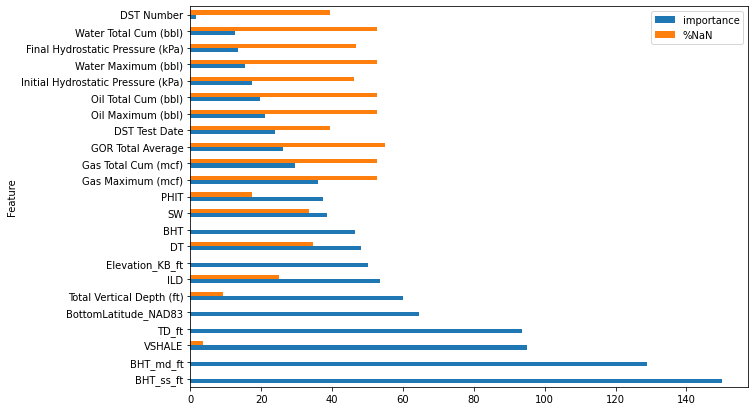

In [37]:
feature_importances.set_index('Feature').plot.barh(figsize=(10,7))
plt.show()

# 5. Feature Engineering

In [38]:
def plot_box(df, params):
  fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(25, 15))
  axs = axs.ravel()

  for ax, i in zip(axs, params):
    ax = sns.boxplot(data=df[i],palette="Set3", ax=ax);
    ax.set_xticks([])
    ax.set_xlabel(i)

In [39]:
def outlier_detector_IQR(df,features,n_IQR, all_data = True):  

  dmin = {}
  dmax = {}
  lower_b = {}
  higher_b = {}
  count_min = {}
  count_max = {}

  for i in features:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit, higher_limit = Q1 - n_IQR*IQR, Q3 +n_IQR*IQR

    lower_b[i] = [np.round(lower_limit,2)]   # min value per Log
    higher_b[i] = [np.round(higher_limit,2)] # max value per Log

    if df[i].min() < lower_limit:      
      dmin[i] = [np.round(df[i].min(),2)]
      count_min[i] = [len(df[i].loc[df[i] < lower_limit])]
    else:
      dmin[i] = '-----'
      count_min[i] = '-----'
    if df[i].max() > higher_limit:
      dmax[i] = [np.round(df[i].max(),2)]
      count_max[i] = [len(df[i].loc[df[i] > higher_limit])]
    else:
      dmax[i] = '-----'
      count_max[i] = '-----'

  lower = pd.DataFrame(lower_b).T.rename(columns={0:'Lower_Limit'})
  min = pd.DataFrame(dmin).T.rename(columns={0:'1st_Min_Outlier'})
  min_count = pd.DataFrame(count_min).T.rename(columns={0:'Total_Min_Out'})
  higher = pd.DataFrame(higher_b).T.rename(columns={0:'Higher_Limit'})  
  max = pd.DataFrame(dmax).T.rename(columns={0:'Last_Max_Outlier'})
  max_count = pd.DataFrame(count_max).T.rename(columns={0:'Total_Max_Out'})  

  return pd.concat([lower,min,min_count,higher,max,max_count],axis=1) 

In [40]:
def outlier_replacer(df,column,min=None,max=None):  

  if min != None:
    min_idx = list(df.loc[df[column]<=min].index.values)
    df.at[min_idx,column] = min
  else:
    pass

  if max != None:
    max_idx = list(df.loc[df[column]>=max].index.values)
    df.at[max_idx,column] = max
  else:
    pass  

  return df

## 5.1 Train Data

In [41]:
selected = np.append(feature_importances['Feature'].values,['UWI','Field','TrueTemp','BottomLongitude_NAD83','RHO','U','GR'])
train = train[selected]
train['Field'] = train[['Field']].replace(to_replace = {'Duvernay':1,'Eaglebine':0})

train['ILD'] = np.log10(train['ILD'])
train = train.set_index('UWI')

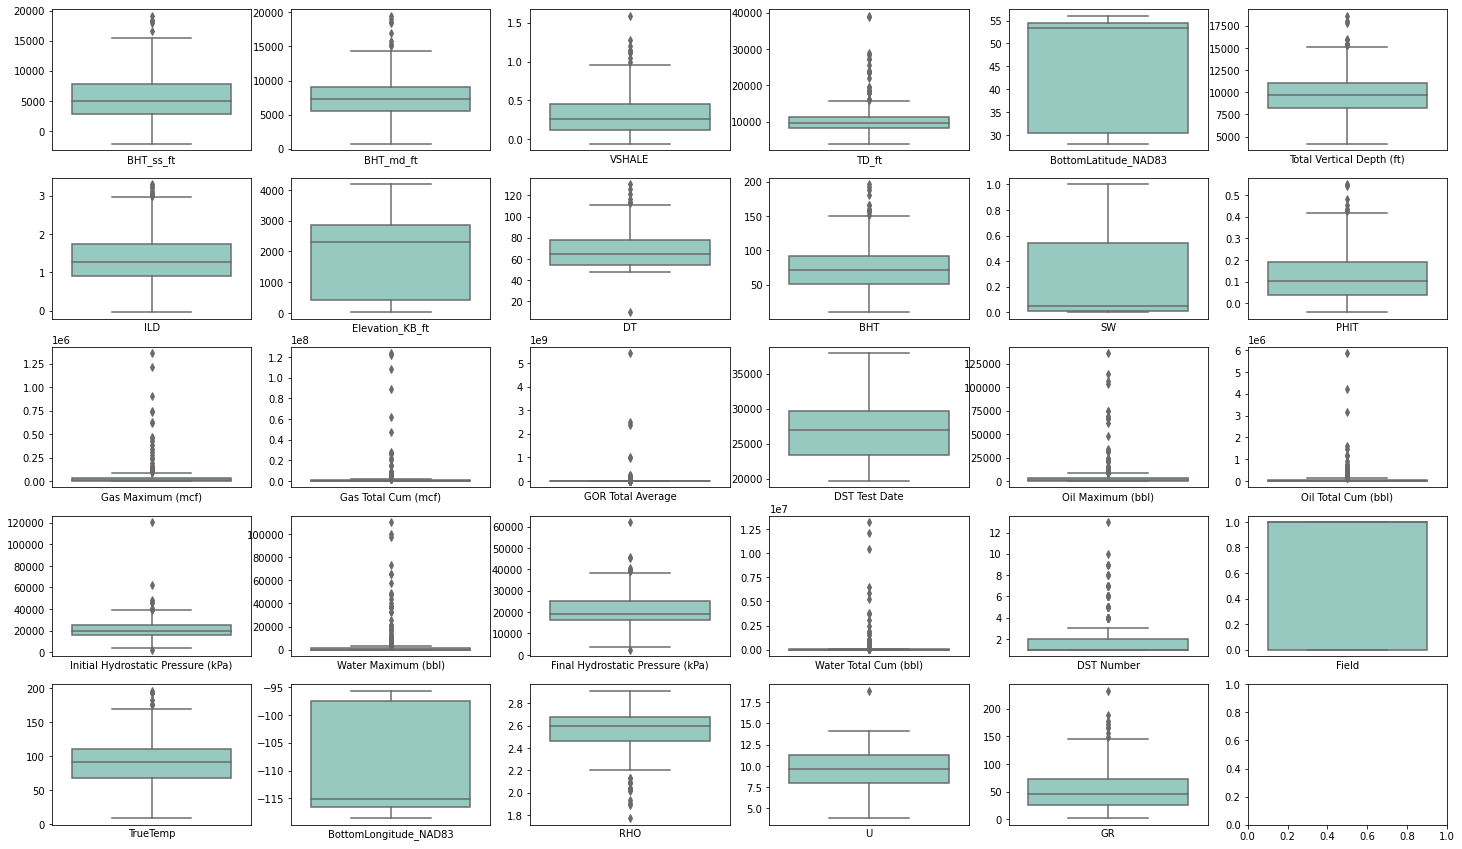

In [42]:
plot_box(train, train.keys())

In [43]:
outlier_detector_IQR(train,train.keys(),1.5)

,Lower_Limit,1st_Min_Outlier,Total_Min_Out,Higher_Limit,Last_Max_Outlier,Total_Max_Out
BHT_ss_ft,-4839.84,-----,-----,15525.51,19132,5
BHT_md_ft,167.25,-----,-----,14424.47,19503,8
VSHALE,-0.40,-----,-----,0.97,1.59,8
TD_ft,3655.11,-----,-----,15830.82,39143.7,23
BottomLatitude_NAD83,-5.69,-----,-----,90.67,-----,-----
Total Vertical Depth (ft),4007.25,-----,-----,15231.25,18626,10
ILD,-0.33,-----,-----,2.97,3.29,9
Elevation_KB_ft,-3240.89,-----,-----,6538.81,-----,-----
DT,20.28,9.8,1,112.42,130.28,6
BHT,-9.11,-----,-----,151.47,196.11,11


In [44]:
outlier_replacer(train,'Gas Maximum (mcf)',min=0,max=19436.24)
outlier_replacer(train,'Oil Total Cum (bbl)',min=0,max=14803.74)
outlier_replacer(train,'Initial Hydrostatic Pressure (kPa)',min=0,max=39112.16)
outlier_replacer(train,'Water Maximum (bbl)',min=0,max=1565.31) 
outlier_replacer(train,'Gas Total Cum (mcf)',min=0,max=227782.69) 
outlier_replacer(train,'Final Hydrostatic Pressure (kPa)',min=0,max=38256.44)  
outlier_replacer(train,'Oil Maximum (bbl)',min=0,max=3295.82) 
outlier_replacer(train,'GOR Total Average',min=0,max=5663.28)
outlier_replacer(train,'Water Total Cum (bbl)',min=0,max=66035.43) 
outlier_replacer(train,'TD_ft',min=None,max=15830.82)
outlier_replacer(train,'Total Vertical Depth (ft)',min=None,max=15231.25) 
outlier_replacer(train,'VSHALE',min=0,max=0.95) 
outlier_replacer(train,'PHIT',min=0,max=None) 
outlier_replacer(train,'ILD',min=0,max=2.97) 
outlier_replacer(train,'DT',min=20.28,max=112.42)
outlier_replacer(train,'GR',min=0,max=143.62) 
outlier_replacer(train,'U',min=None,max=16.16) 
output.clear()

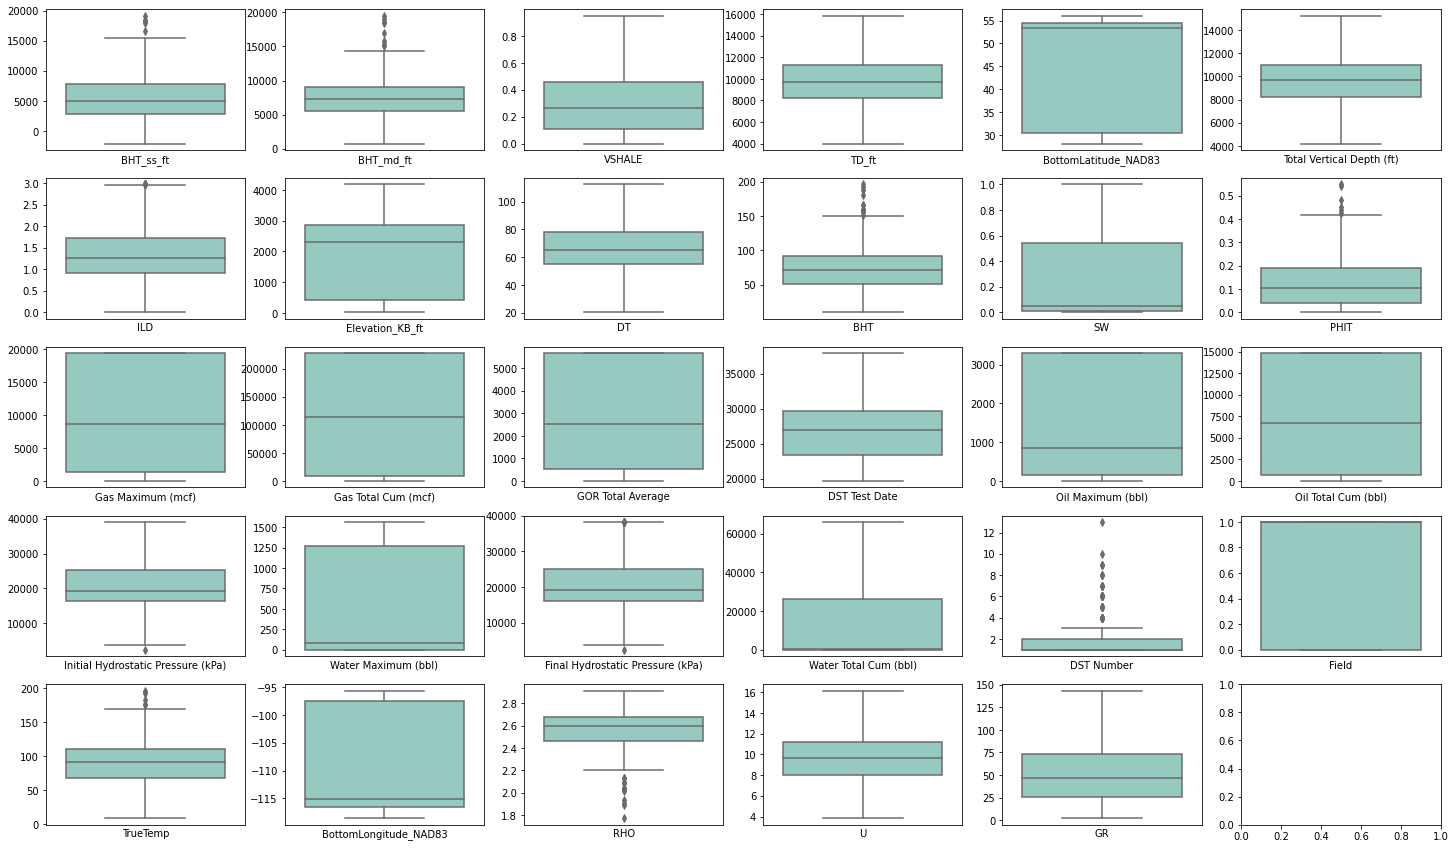

In [45]:
plot_box(train, train.keys())

In [46]:
# del train['Total Vertical Depth (ft)']
# del train['DST Number']
# del train['DST Test Date']

In [47]:
train['thermal_grad'] = ((train['BHT']-15.5)+273.15)/(train['BHT_md_ft']/3.28) # K/m

In [48]:
train.groupby(by='Field')['thermal_grad'].mean()

Field
0    0.140763
1    0.186091
Name: thermal_grad, dtype: float64

In [49]:
train['thermal_grad'].describe()

count    615.000000
mean       0.168181
std        0.081410
min        0.071361
25%        0.124261
50%        0.149030
75%        0.185248
max        1.309485
Name: thermal_grad, dtype: float64

In [50]:
# outlier_replacer(train,'thermal_grad',min=None,max=6.21)
# output.clear()

In [51]:
# 1. Define ordet to fill:
#########################################

features = ['BHT_ss_ft','BHT_md_ft','TD_ft','BottomLatitude_NAD83','BottomLongitude_NAD83','Elevation_KB_ft','BHT','Field','thermal_grad',
            'Total Vertical Depth (ft)','VSHALE','GR','PHIT','ILD','SW','DT','RHO','U']             

# 2. Define Log Fill Function
##########################################

def nan_filler(df,log,labels):

  df_filter = df[df[log].notnull()].copy() 
  df_missing = df[df[log].isnull()].copy() 

  X_train_rf = np.array(df_filter[labels])
  y_train_rf = np.array(df_filter[log])

  X_test_rf = np.array(df_missing[labels])

  model_rf = RandomForestRegressor(n_estimators=300,random_state=42)
  
  model_rf.fit(X_train_rf, y_train_rf)

  y_pred = model_rf.predict(X_test_rf)

  n = df[log].isna()
  df.loc[n, log] = y_pred

  return df

# 3. Fill Dataset
########################################
nan = train[features].isna().sum().sum()

while nan > 0:
  for log in features[9:]:
    filled = nan_filler(train[features], log, features[ 0 : np.where(np.array(features) == log )[0][0]])
    train[log] = filled[log]
    nan = train[features].isna().sum().sum()
  if nan == 0:
    break  

In [52]:
train.isna().sum().sort_values()

BHT_ss_ft                               0
U                                       0
RHO                                     0
BottomLongitude_NAD83                   0
TrueTemp                                0
Field                                   0
GR                                      0
PHIT                                    0
SW                                      0
thermal_grad                            0
DT                                      0
Elevation_KB_ft                         0
BHT_md_ft                               0
VSHALE                                  0
ILD                                     0
TD_ft                                   0
BottomLatitude_NAD83                    0
BHT                                     0
Total Vertical Depth (ft)               0
DST Test Date                         243
DST Number                            243
Initial Hydrostatic Pressure (kPa)    284
Final Hydrostatic Pressure (kPa)      287
Water Maximum (bbl)               

In [53]:
for i in train.keys():
  if train[i].isna().sum() > 0:
    train.fillna(-999.99,inplace=True)

## 5.1.1 Thermal Properties

In [54]:
train['thermal_cond'] = 1.15 + 2.59*(train['RHO']*1000) + 1.08*train['PHIT'] - 0.28*train['U'] - 0.0083*((train['BHT']-15.5)+273.15) - 1.66*train['VSHALE']
train['thermal_diff'] = 1.59 + 0.57*(train['RHO']*1000) - 0.70*train['PHIT'] - 0.113*train['U'] - 0.0043*((train['BHT']-15.5)+273.15) - 0.45*train['VSHALE']
# train['heat_capacity'] = 584 - 194.4*(train['RHO']*1000) + 1250*train['PHIT'] + 10.93*train['U'] + 4.03*((train['BHT']-15.5)+273.15) - 435.9*train['VSHALE']
train['heat_flux'] = train['thermal_cond']*train['thermal_grad'] # W/M2

## 5.2 Test Data

In [55]:
test = test[selected]
test['Field'] = test[['Field']].replace(to_replace = {'Duvernay':1,'Eaglebine':0})
test['ILD'] = np.log10(test['ILD'])
test = test.set_index('UWI')

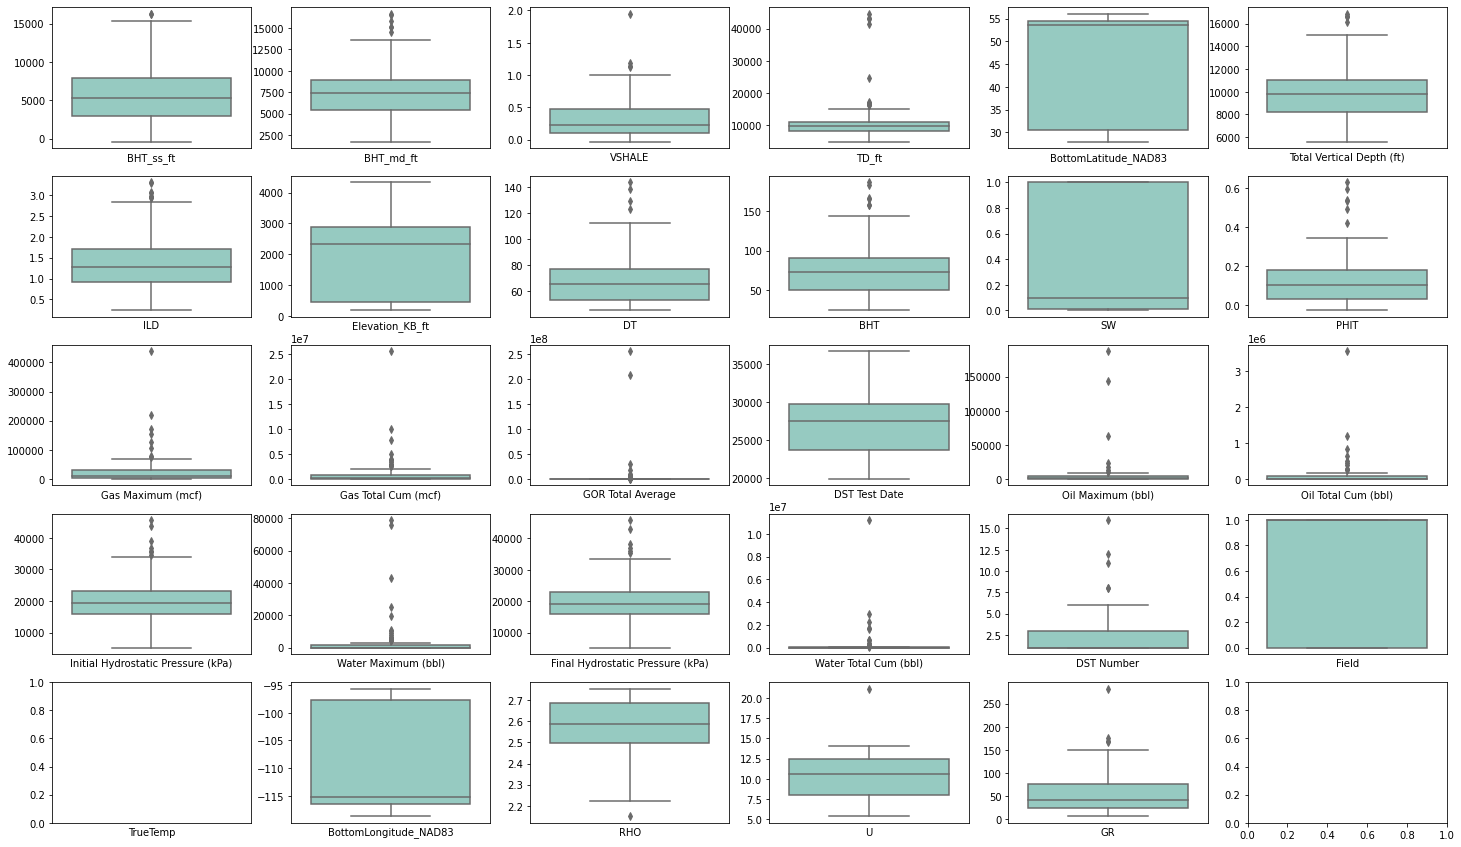

In [56]:
plot_box(test, test.keys())

In [57]:
outlier_detector_IQR(test,test.keys(),1.5)

,Lower_Limit,1st_Min_Outlier,Total_Min_Out,Higher_Limit,Last_Max_Outlier,Total_Max_Out
BHT_ss_ft,-4597.85,-----,-----,15474.32,16282,2
BHT_md_ft,292.18,-----,-----,14089.92,16653.8,6
VSHALE,-0.43,-----,-----,1.01,1.95,4
TD_ft,3986.47,-----,-----,15229.22,44619.8,11
BottomLatitude_NAD83,-5.70,-----,-----,90.73,-----,-----
Total Vertical Depth (ft),4048.50,-----,-----,15180.50,16865,4
ILD,-0.26,-----,-----,2.87,3.3,7
Elevation_KB_ft,-3204.05,-----,-----,6554.43,-----,-----
DT,17.64,-----,-----,112.81,143.44,4
BHT,-10.97,-----,-----,152.36,185.56,6


In [58]:
outlier_replacer(test,'Oil Total Cum (bbl)',min=0,max=215185.48)
outlier_replacer(test,'Initial Hydrostatic Pressure (kPa)',min=0,max=34086.60)
outlier_replacer(test,'Water Maximum (bbl)',min=0,max=3759.20) 
outlier_replacer(test,'Gas Maximum (mcf)',min=0,max=72158.76)
outlier_replacer(test,'Gas Total Cum (mcf)',min=0,max=2121329.22) 
outlier_replacer(test,'Final Hydrostatic Pressure (kPa)',min=0,max=33843.45)  
outlier_replacer(test,'Oil Maximum (bbl)',min=0,max=9898.56) 
outlier_replacer(test,'GOR Total Average',min=0,max=276093.68)
outlier_replacer(test,'Water Total Cum (bbl)',min=0,max=93234.20) 
outlier_replacer(test,'TD_ft',min=None,max=15229.22)
outlier_replacer(test,'Total Vertical Depth (ft)',min=None,max=15180.50) 
outlier_replacer(test,'VSHALE',min=0,max=1) 
outlier_replacer(test,'PHIT',min=0,max=0.41) 
outlier_replacer(test,'ILD',min=0,max=2.87) 
outlier_replacer(test,'DT',min=17.64,max=112.81)
outlier_replacer(test,'GR',min=0,max=150.91) 
outlier_replacer(test,'U',min=None,max=19.05) 
output.clear()

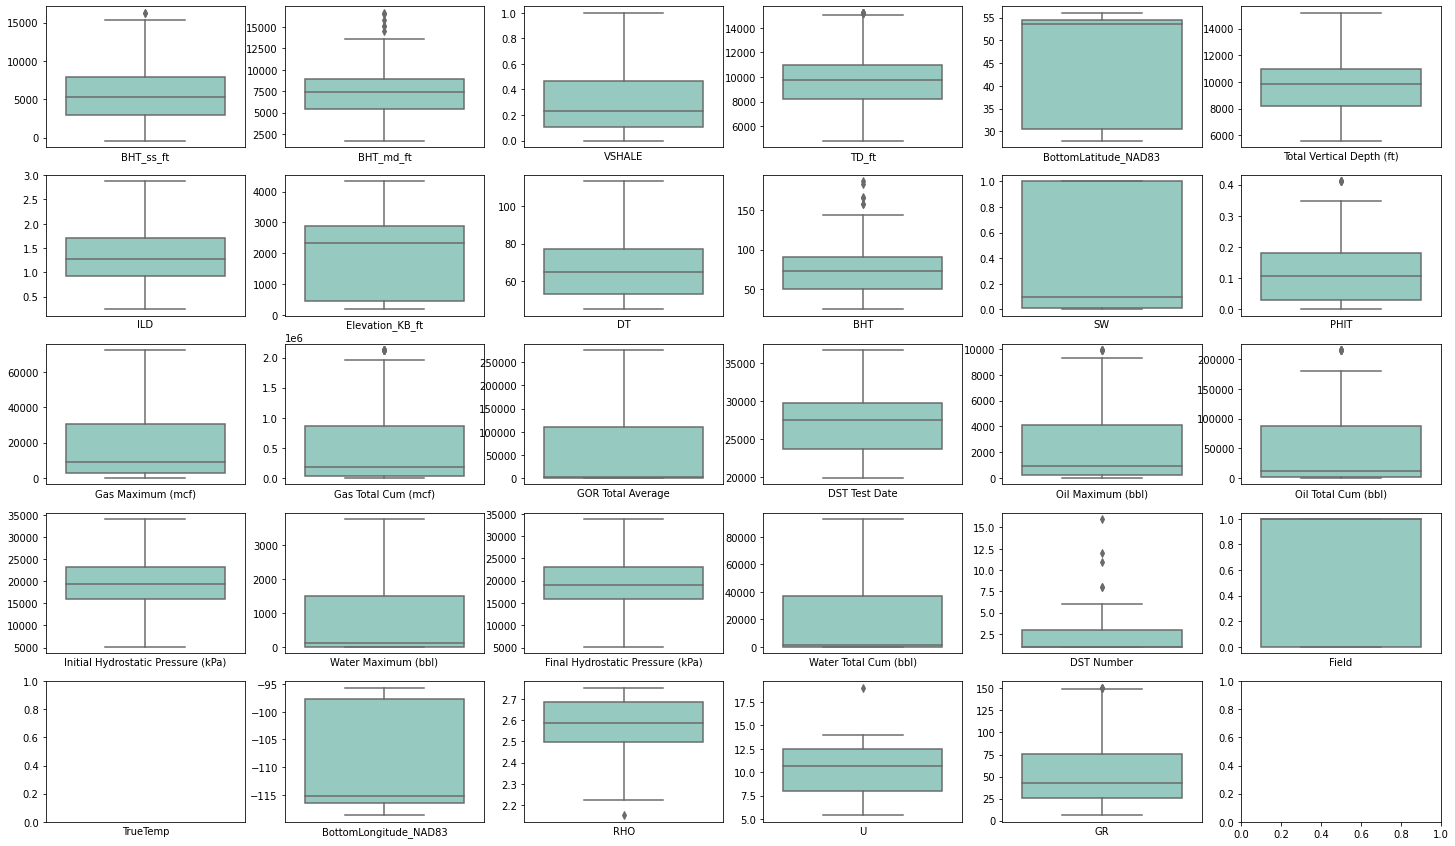

In [59]:
plot_box(test, test.keys())

In [60]:
# del test['Total Vertical Depth (ft)']
# del test['DST Number']
# del test['DST Test Date']

In [61]:
test['thermal_grad'] = ((test['BHT']-15.5)+273.15)/((test['BHT_md_ft'])/3.28) # K/m

In [62]:
test.groupby(by='Field')['thermal_grad'].mean()

Field
0    0.136906
1    0.182585
Name: thermal_grad, dtype: float64

In [63]:
test['thermal_grad'].describe()

count    206.000000
mean       0.165067
std        0.064600
min        0.074050
25%        0.125613
50%        0.146002
75%        0.185410
max        0.548729
Name: thermal_grad, dtype: float64

In [64]:
# 1. Define ordet to fill:
#########################################

features = ['BHT_ss_ft','BHT_md_ft','TD_ft','BottomLatitude_NAD83','BottomLongitude_NAD83','Elevation_KB_ft','BHT','Field','thermal_grad',
            'Total Vertical Depth (ft)','VSHALE','GR','PHIT','ILD','SW','DT','RHO','U'] 
            
# 2. Define Log Fill Function
##########################################

def nan_filler(df,log,labels):

  df_filter = df[df[log].notnull()].copy() 
  df_missing = df[df[log].isnull()].copy() 

  X_train_rf = np.array(df_filter[labels])
  y_train_rf = np.array(df_filter[log])

  X_test_rf = np.array(df_missing[labels])

  # model_rf = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
  #                  importance_type='gain', learning_rate=0.1, 
  #                  max_depth=4, n_estimators=150,gamma=7,
  #                  n_jobs=1, objective='reg:squarederror', random_state=42,
  #                  reg_alpha=0, reg_lambda=1, subsample=1,shuffle=True)

  model_rf = RandomForestRegressor(n_estimators=150,random_state=42)
  
  model_rf.fit(X_train_rf, y_train_rf)

  y_pred = model_rf.predict(X_test_rf)

  n = df[log].isna()
  df.loc[n, log] = y_pred

  return df

# 3. Fill Dataset
########################################
nan = test[features].isna().sum().sum()

while nan > 0:
  for log in features[9:]:
    filled = nan_filler(test[features], log, features[ 0 : np.where(np.array(features) == log )[0][0]])
    test[log] = filled[log]
    nan = test[features].isna().sum().sum()
  if nan == 0:
    break  

In [65]:
for i in test.keys():
  if test[i].isna().sum()>0:
    test.fillna(-999.99,inplace=True)

## 5.2.1 Thermal Properties

In [66]:
test['thermal_cond'] = 1.15 + 2.59*(test['RHO']*1000) + 1.08*test['PHIT'] - 0.28*test['U'] - 0.0083*((test['BHT']-15.5)+273.15) - 1.66*test['VSHALE']
test['thermal_diff'] = 1.59 + 0.57*(test['RHO']*1000) - 0.70*test['PHIT'] - 0.113*test['U'] - 0.0043*((test['BHT']-15.5)+273.15) - 0.45*test['VSHALE']
# test['heat_capacity'] = 584 - 194.4*(test['RHO']*1000) + 1250*test['PHIT'] + 10.93*test['U'] + 4.03*((test['BHT']-15.5)+273.15) - 435.9*test['VSHALE']
test['heat_flux'] = test['thermal_cond']*test['thermal_grad'] # W/M2

# 6. Model Building

## Random Forest

In [67]:
test['TrueTemp'] = np.nan

In [68]:
from sklearn.ensemble import RandomForestRegressor

X_train = train.drop('TrueTemp',axis=1).values
y_train = train['TrueTemp'].values.reshape(-1,1)

forest = RandomForestRegressor(n_estimators=1000)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [69]:
# test = test.set_index('UWI')
X_test = test.drop('TrueTemp',axis=1).values
prediction = forest.predict(X_test)

In [70]:
prediction

array([114.17696667,  53.67505321,  93.56012111,  90.50870889,
        87.27171556,  37.86507778,  97.51518667, 106.84381555,
        42.18918556,  53.99578333,  66.92574889,  97.90956   ,
        72.50696667,  71.60120333,  80.92105889,  74.92994889,
        72.58453444,  66.98467444,  81.20096333,  64.43684   ,
        66.38703778,  52.55268173,  65.58159556,  95.14166889,
        84.27581889, 110.09310667,  85.73719667, 109.08067111,
        53.93186185,  65.11883556,  54.96630617,  72.37372667,
        39.53930889,  73.20892667, 105.18034778, 106.34402   ,
       104.89145556,  78.17937556,  53.92045667,  37.29146   ,
        99.26870111,  77.33759556,  53.91321802,  98.99174444,
        97.95022667,  35.53393667,  73.36251333,  78.43911889,
        76.34312111,  74.95580667,  93.20948667, 119.69871222,
       115.35649222,  82.24787222,  39.10641444,  71.55503839,
        66.72913444,  67.11767   ,  69.54536   ,  66.42329667,
        68.76749   ,  70.09301778,  64.64575   ,  64.67

In [72]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zEQuZplE6ftr9Z03YTuVCSU7uxIZ0cPE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zEQuZplE6ftr9Z03YTuVCSU7uxIZ0cPE" -O reference.csv && rm -rf /tmp/cookies.txt
output.clear()
reference = pd.read_csv('reference.csv')


In [73]:
reference = reference.drop('Unnamed: 0',axis=1)
reference

,UWI,TrueTemp
0,100012404516W502,114.379396
1,100012805703W500,53.681739
2,100020206419W500,93.605883
3,100020605904W500,90.224006
4,100020606216W500,87.929592
...,...,...
201,42493306840000,110.770478
202,42493311060000,77.476269
203,42493311680000,91.682112
204,42493322270000,91.571810


In [74]:
test['TrueTemp'] = prediction
test = test.reset_index()
test = test.rename(columns={'index':'UWI'})
test[['UWI','TrueTemp']].to_csv('predictions.csv')

In [75]:
from sklearn.metrics import mean_squared_error as mse 

mse(test['TrueTemp'],reference['TrueTemp'])

0.14544358651278966

In [ ]:
import zipfile
zipfile.ZipFile('predictions.zip', mode='w').write("predictions.csv")

## MLP

In [ ]:
X_train = train.drop('TrueTemp',axis=1).copy()
y_train = train[['TrueTemp']].copy()

X_test = test.drop('TrueTemp',axis=1).copy()

In [ ]:
from sklearn.preprocessing import  MinMaxScaler

def minmax_scaler(data, minmaxrange=(0,1)):
    scaler = MinMaxScaler(feature_range = minmaxrange)
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

In [ ]:
# Here we scale the training inputs and create the scaler to be used to scale testing data and for inverse transform after simulation
X_train_scaled, X_scaler = minmax_scaler(X_train, minmaxrange=(0,1))
X_test_scaled = X_scaler.transform(X_test)

# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Here we do the same for the targets
y_train_scaled, y_scaler = minmax_scaler(y_train.values.reshape(-1,1), minmaxrange=(0,1))

# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe
y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index, columns=y_train.columns)


In [ ]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from keras.layers import Dense, Dropout
from keras.models import Sequential
from tensorflow.keras import initializers
from keras.optimizers import Adam

# %%time
# Train models and keep them in memory 
# This is where we define the amount of models in the ensemble
# We save those models to a list 'models'
n_members = 10
model_store = []

# We store our training performance in 'history_store'
history_store = []

#here we define model architecture and train the neural network in a loop for each model 
for i in range(n_members): 
    model = Sequential()
    
    # Adding layers
    model.add(layers.Dense(64, activation='relu', input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform'))
    model.add(layers.Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dense(16, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dense(8, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dense(4, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dense(2, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dense(y_train_scaled.shape[1], activation='linear'))
    
    # Setting optimizer
    opt = keras.optimizers.Adam(learning_rate=0.001)
    
    # Compile model and add callbacks
    model.compile(optimizer=opt, loss='mse')
    
    # Fit and save! 
    history_store.append(model.fit(X_train_scaled, 
                                   y_train_scaled, 
                                   epochs=1000, validation_split=0.1,
                                   shuffle=True, batch_size=310,
                                   verbose=0))
    model_store.append(model)
    
    # Some basic print statements for updating us during training
    loss = history_store[i].history['loss']
    epochs = range(len(loss))
    print('-------------------------------------------------- Completed Training of Model #', i)
    print('-------------------------------------------------- Total Epochs Range:', epochs )
    print('-----------------------------------------------------------------------------------')

-------------------------------------------------- Completed Training of Model # 0
-------------------------------------------------- Total Epochs Range: range(0, 1000)
-----------------------------------------------------------------------------------
-------------------------------------------------- Completed Training of Model # 1
-------------------------------------------------- Total Epochs Range: range(0, 1000)
-----------------------------------------------------------------------------------
-------------------------------------------------- Completed Training of Model # 2
-------------------------------------------------- Total Epochs Range: range(0, 1000)
-----------------------------------------------------------------------------------
-------------------------------------------------- Completed Training of Model # 3
-------------------------------------------------- Total Epochs Range: range(0, 1000)
------------------------------------------------------------------------

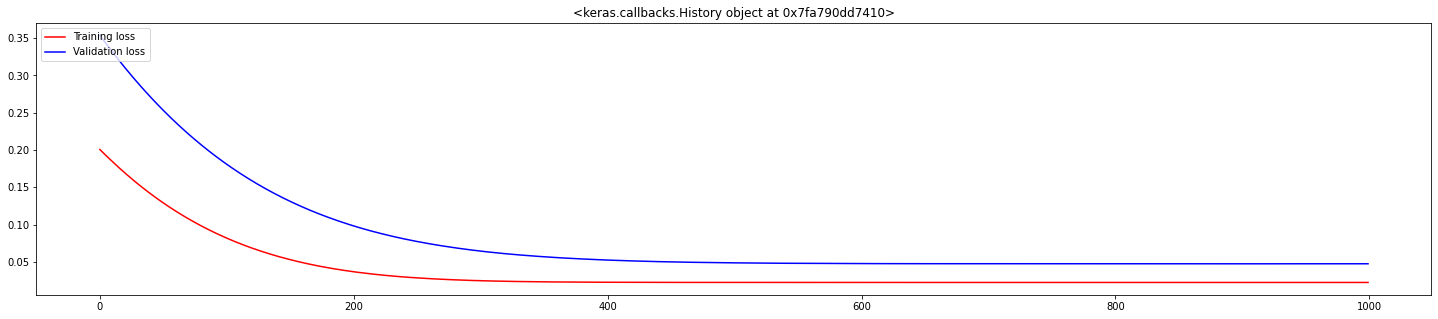

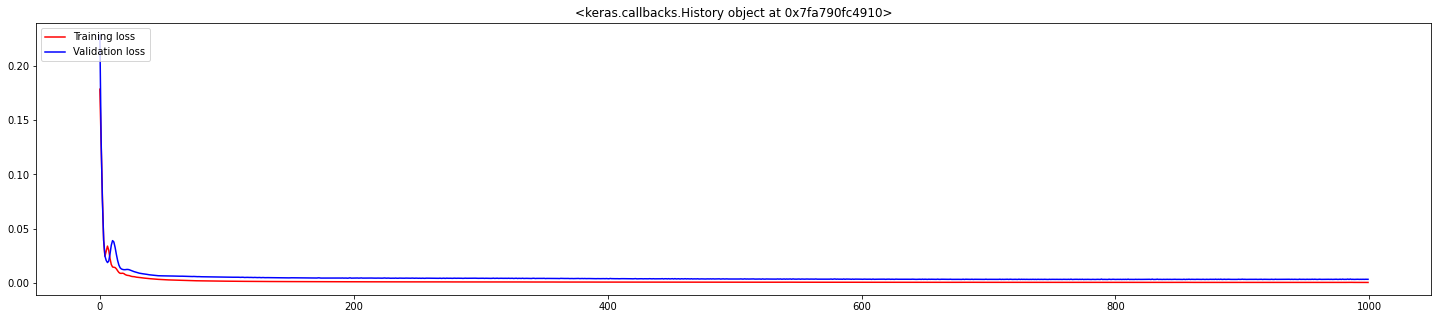

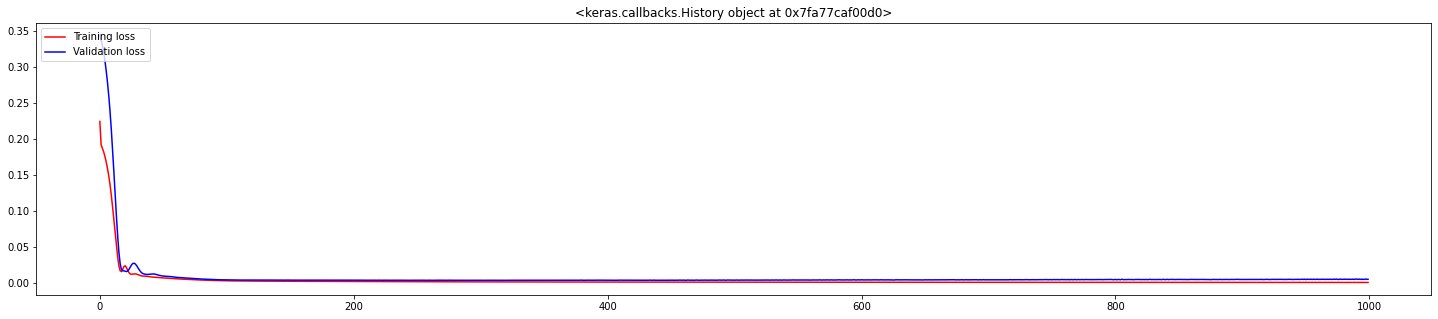

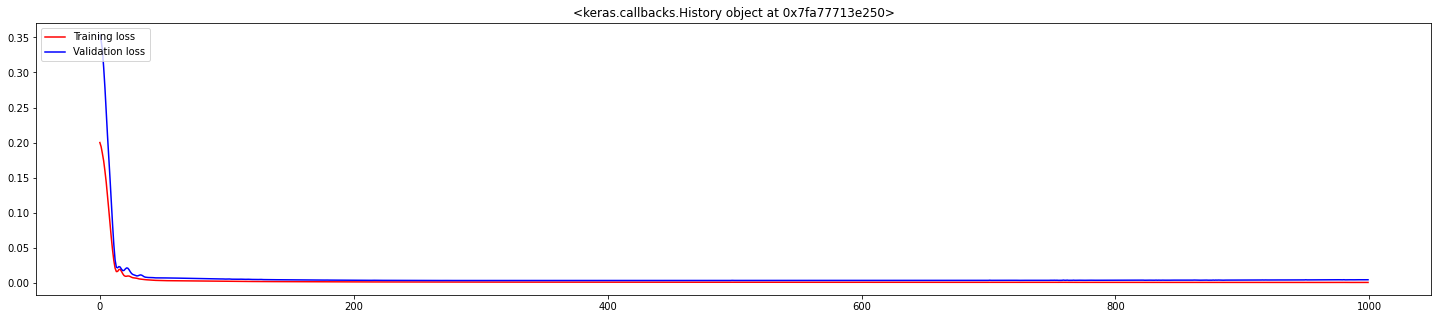

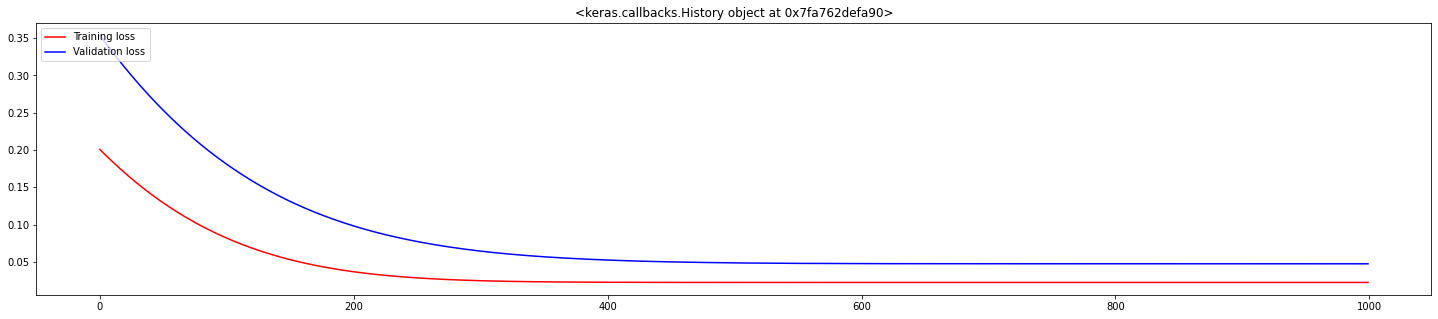

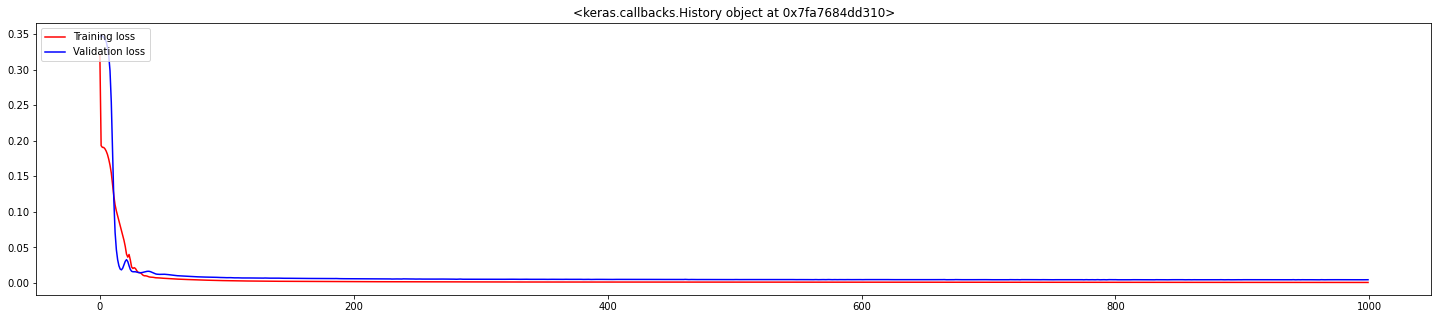

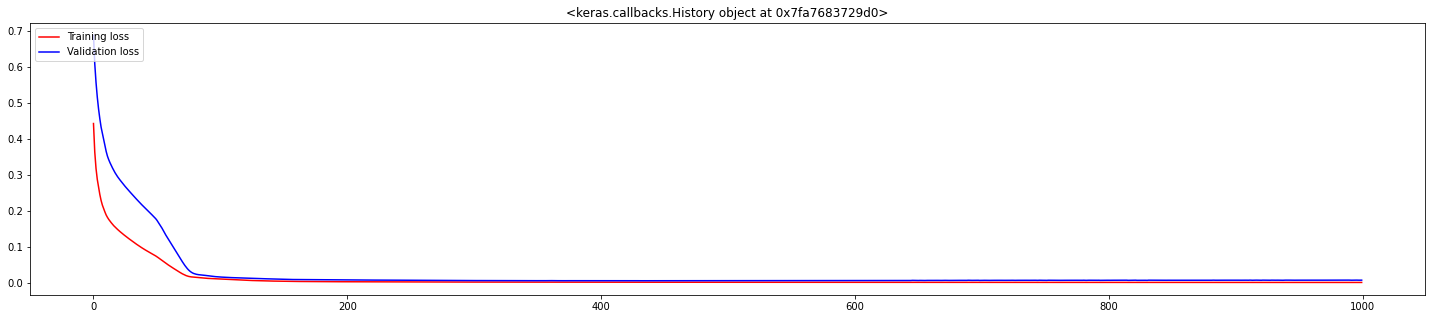

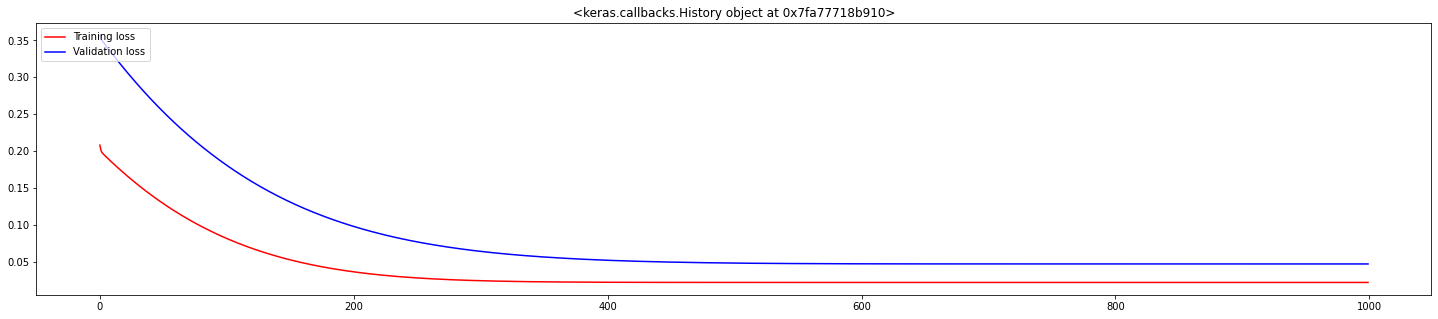

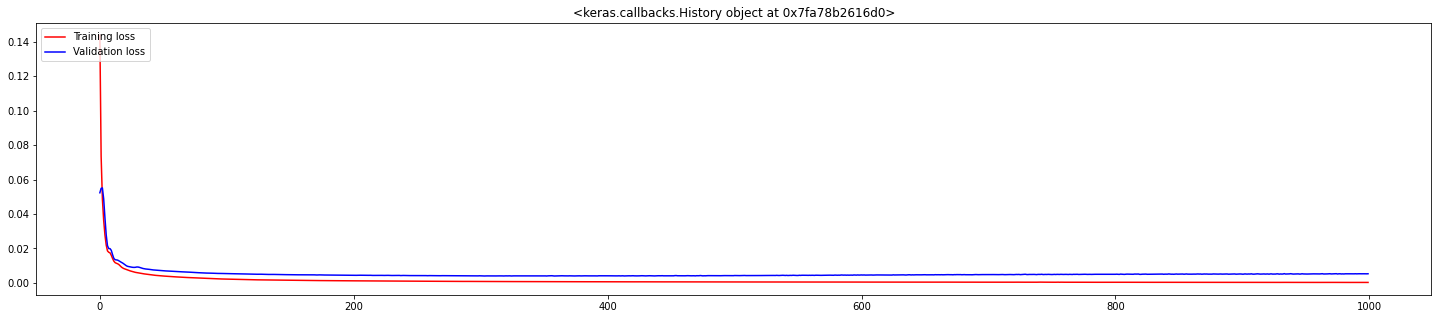

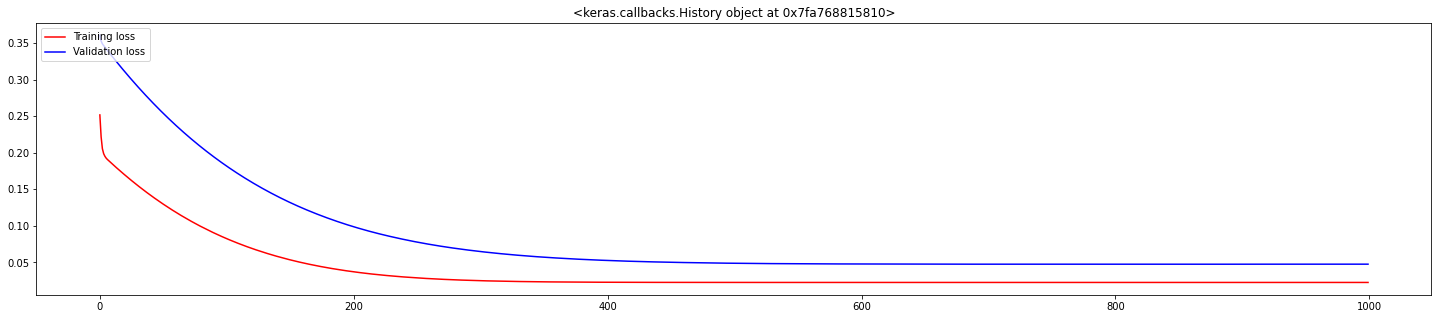

In [ ]:
for history in history_store:
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure(figsize=(25,5))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.legend(loc='upper left')
    plt.title(str(history))

In [ ]:
yhats = [y_scaler.inverse_transform(model.predict(X_test_scaled)) for model in model_store]
yhats = np.array(yhats)

In [ ]:
prediction = yhats.mean(0)

In [ ]:
prediction

array([[110.13722 ],
       [ 65.29628 ],
       [ 90.19905 ],
       [ 84.17518 ],
       [ 84.69489 ],
       [ 70.29015 ],
       [ 93.04143 ],
       [251.54944 ],
       [ 89.1929  ],
       [ 67.07695 ],
       [116.17869 ],
       [118.29514 ],
       [ 80.59116 ],
       [116.46957 ],
       [ 83.884705],
       [249.07344 ],
       [ 78.56881 ],
       [ 73.27031 ],
       [ 84.64217 ],
       [ 73.057816],
       [ 76.2675  ],
       [ 65.589455],
       [ 75.1717  ],
       [ 90.61529 ],
       [ 83.9156  ],
       [101.08517 ],
       [ 81.14415 ],
       [ 95.03014 ],
       [ 64.0692  ],
       [ 90.65176 ],
       [ 91.178116],
       [ 75.73996 ],
       [ 63.344933],
       [ 77.33873 ],
       [ 96.6425  ],
       [ 96.934685],
       [102.14795 ],
       [ 83.21331 ],
       [ 69.14793 ],
       [ 59.89214 ],
       [ 92.826065],
       [ 78.558014],
       [ 63.98053 ],
       [ 92.00153 ],
       [ 93.95152 ],
       [ 55.066246],
       [262.32233 ],
       [ 81.3

In [ ]:
test['TrueTemp'] = prediction
test = test.reset_index()
test = test.rename(columns={'index':'UWI'})
test[['UWI','TrueTemp']].to_csv('predictions.csv')